<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Partie-1:-Altération-d'une-image" data-toc-modified-id="Partie-1:-Altération-d'une-image-1">Partie 1: Altération d'une image</a></span></li><li><span><a href="#Partie-2:-Restauration-d'image" data-toc-modified-id="Partie-2:-Restauration-d'image-2">Partie 2: Restauration d'image</a></span></li><li><span><a href="#Partie-3:-Implémentation-de-l'ADMM-pour-résoudre-le-problème-de-restauration-d'image" data-toc-modified-id="Partie-3:-Implémentation-de-l'ADMM-pour-résoudre-le-problème-de-restauration-d'image-3">Partie 3: Implémentation de l'ADMM pour résoudre le problème de restauration d'image</a></span></li></ul></div>

# TP3: Restauration d'image à l'aide de l'ADMM
*<p>Author: Pengfei MI</p>*
*<p>Date: 23/06/2017</p>*

In [1]:
import numpy as np
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import pickle

## Partie 1: Altération d'une image

In [2]:
# Data manipulation

# Ouvrir des données stockées dans un fichier .pk
data = pickle.load(open('data.pk','rb'))

# Charger par exemple la matrice H
#H = data.get('H')

# Sauvegarder des données dans un fichier .pk
#pickle.dump({'obj1': obj1, 'obj2':obj2}, open('filename.pk','wb'), pickle.HIGHEST_PROTOCOL)

$\textbf{Manipulation 1} \quad\text{Observer l'effet du flou de bougé sur les observations.}$

[u'H', u'observations', u'T', u'original']
Convolution matrix:  (4096, 4096)
Original image:  (64, 64)
Observed image:  (64, 64)
Total variation matrix:  (8064, 4096)


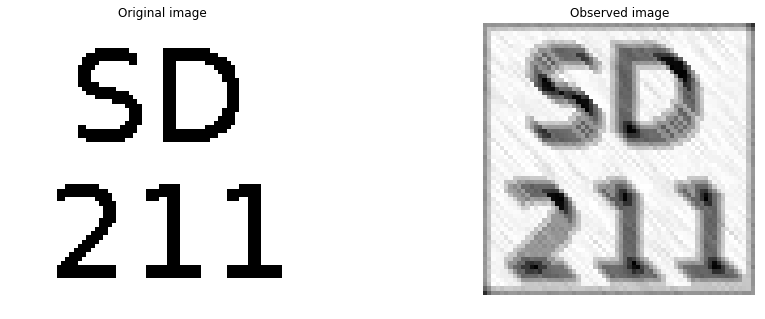

In [3]:
print data.keys()

print "Convolution matrix: ", data['H'].shape
print "Original image: ", data['original'].shape
print "Observed image: ", data['observations'].shape
print "Total variation matrix: ", data['T'].shape

plt.figure(1, figsize=(15,5))
plt.subplot(121)
plt.title("Original image")
plt.imshow(data['original'], cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.title("Observed image")
plt.imshow(data['observations'], cmap='gray')
plt.axis('off')
plt.show()

## Partie 2: Restauration d'image

$\textbf{Préparation 1}\quad \text{Écrire le problème de restauration d'image (3) sous la forme (5). Exprimer les fonctions }f\text{ et }g\text{, le vecteur }\mathbf{z}\text{ et la matrice }\mathbf{A}\text{.}$

<div class="alert alert-success">
$\mathbf{z}_1 = \mathbf{x} \in \mathbb{R}^P, \mathbf{z}_2 = \mathbf{Tx} \in \mathbb{R}^{2P-K-L}$ et $\mathbf{z} = [\mathbf{z}_1^T, \mathbf{z}_2^T]^T$, donc on a:
$$
\begin{align}
& \mathbf{\iota}_{[0,1]^P}(\mathbf{z}_1) = \mathbf{\iota}_{[0,1]^P}(\mathbf{B}_1\mathbf{z}), \quad\text{où}\ \mathbf{B}_1 = diag(\underbrace{1,...,1}_{P}, \underbrace{0,...,0}_{2P-K-L}) \\
& \|\mathbf{z}_2\|_1 = \|\mathbf{B}_2\mathbf{z}\|_1, \quad\text{où}\ \mathbf{B}_2 = diag(\underbrace{0,...,0}_{P}, \underbrace{1,...,1}_{2P-K-L})
\end{align}
$$

Alors
$$
\begin{align}
& \underset{\mathbf{x}}{\text{min}}\ \frac{1}{2}\|\mathbf{y}-\mathbf{Hx}\|_2^2 + \beta\|\mathbf{Tx}\|_1 + \mathbf{\iota}_{[0,1]^P}(\mathbf{x}) \\
=\ & \underset{\mathbf{x}}{\text{min}}\ \frac{1}{2}\|\mathbf{y}-\mathbf{Hx}\|_2^2 + \beta\|\mathbf{z}_2\|_1 + \mathbf{\iota}_{[0,1]^P}(\mathbf{z}_1) \\
=\ & \underset{\mathbf{x}}{\text{min}}\ \frac{1}{2}\|\mathbf{y}-\mathbf{Hx}\|_2^2 + \beta\|\mathbf{B}_2\mathbf{z}\|_1 + \mathbf{\iota}_{[0,1]^P}(\mathbf{B}_1\mathbf{z}) \\
=\ & \underset{\mathbf{x}}{\text{min}}\ f(\mathbf{x}) + g(\mathbf{z})
\end{align}
$$
où $f(\mathbf{x}) = \frac{1}{2}\|\mathbf{y}-\mathbf{Hx}\|_2^2$, $g(\mathbf{z}) = \beta\|\mathbf{B}_2\mathbf{z}\|_1 + \mathbf{\iota}_{[0,1]^P}(\mathbf{B}_1\mathbf{z})$, avec $\mathbf{B}_1$ et $\mathbf{B}_2$ définies comme précédentes.

<p>
$\nabla_{\mathbf{x}} f = \mathbf{H}^T(\mathbf{Hx} - \mathbf{y})$, $\nabla_{\mathbf{x}}^2 f = \mathbf{H}^T\mathbf{H}$, donc la matrice hessienne de $f(\mathbf{x})$ est positive semi-définie, $f(\mathbf{x})$ est convexe,
</p>

<p>
$g(\mathbf{z})$ est convexe pour tout $\beta > 0$,
</p>

<p>
Donc le problème peut s'écrire sous la forme (5), $\mathbf{A} = 
\begin{pmatrix}
\mathbf{I}_{P} \\
\mathbf{T}
\end{pmatrix} \in \mathbb{R}^{(3P-K-L)\ \times\ P}$.
</p>
</div>

$\textbf{Préparation 2}\quad \text{Ecrire le Lagrangien augmenté }\mathcal{L}_\rho\text{ du problème de restauration d'image (3).}$

<div class="alert alert-success">
$$\mathcal{L}_\rho(\mathbf{x}, \mathbf{z}^k, \mathbf{\gamma}^k)\ =\ \frac{1}{2}\|\mathbf{y}-\mathbf{Hx}\|_2^2 + \mathbf{\iota}_{[0,1]^P}(\mathbf{z}_1) + \beta\|\mathbf{z}_2\|_1 + \mathbf{\gamma}_1^T(\mathbf{x}-\mathbf{z}_1) + \mathbf{\gamma}_2^T(\mathbf{Tx}-\mathbf{z}_2) + \frac{\rho}{2}\|\mathbf{x}-\mathbf{z}_1\|_2^2 + \frac{\rho}{2}\|\mathbf{Tx}-\mathbf{z}_2\|_2^2$$
</div>

$\textbf{Préparation 3}\quad \text{Ecrire l'étape de minimisation de }\mathcal{L}_\rho \text{ selon la variable }\mathbf{x}\text{.}$

<div class="alert alert-success">
$$\nabla_x \mathcal{L}_\rho = \mathbf{H}^T(\mathbf{Hx-y}) + \gamma_1 + \mathbf{T}^T\gamma_2 + \rho(\mathbf{x}-\mathbf{z}_1) + \rho\mathbf{T}^T(\mathbf{Tx}-\mathbf{z}_2)$$
Soit $\nabla_x \mathcal{L}_\rho = 0$, on a:
$$\mathbf{x}^{k+1} = (\mathbf{H}^T\mathbf{H} + \rho\mathbf{I}_P + \rho\mathbf{T}^T\mathbf{T})^{-1}(\mathbf{H}^T\mathbf{y} + \rho\mathbf{z}_1^k + \rho\mathbf{T}^T\mathbf{z}_2^k - \gamma_1^k - \mathbf{T}^T\gamma_2^k)$$
</div>

$\textbf{Préparation 4}\quad \text{Ecrire l'étape de minimisation de }\mathcal{L}_\rho \text{ selon la variable }\mathbf{z}_1\text{ et }\mathbf{z}_2\text{.}$

<div class="alert alert-success">
$$
\begin{aligned}
\text{arg}\ \underset{\mathbf{z}_1}{\text{min}}\ \mathcal{L}_\rho &= \text{arg}\ \underset{\mathbf{z}_1}{\text{min}}\ \mathbf{\iota}_{[0,1]^P}(\mathbf{z}_1) + \mathbf{\gamma}_1^T(\mathbf{x}-\mathbf{z}_1) + \frac{\rho}{2}\|\mathbf{x}-\mathbf{z}_1\|_2^2 \\
&= \text{arg}\ \underset{\mathbf{z}_1 \in [0,1]^P}{\text{min}}\ \mathbf{\gamma}_1^T(\mathbf{x}-\mathbf{z}_1) + \frac{\rho}{2}\|\mathbf{x}-\mathbf{z}_1\|_2^2
\end{aligned}
$$

Soit la dérivé de la fonction objectif:
$$-\mathbf{\gamma}_1 + \rho(\mathbf{z}_1 - \mathbf{x}) = 0 \quad \Rightarrow \quad \mathbf{z}_1 = \frac{\mathbf{\gamma}_1}{\rho} + \mathbf{x}$$

En considérant la contrainte sur la domaine, pour chaque élément $\mathbf{z}_{1,n},\ 1 \leq n \leq P$, on a:
$$\mathbf{z}_{1,n}^{k+1} = \text{max}(0,\ \text{min}(1,\ \frac{\mathbf{\gamma}_{1,n}^k}{\rho} + \mathbf{x}_n^{k+1})$$
</div>

<div class="alert alert-success">
$$\text{arg}\ \underset{\mathbf{z}_2}{\text{min}}\ \mathcal{L}_\rho = \text{arg}\ \underset{\mathbf{z}_2}{\text{min}}\ \beta\|\mathbf{z}_2\|_1 + \mathbf{\gamma}_2^T(\mathbf{Tx}-\mathbf{z}_2) + \frac{\rho}{2}\|\mathbf{Tx}-\mathbf{z}_2\|_2^2$$

<p>
La fonction objectif peut s'écrit de la forme $\mathcal{L}_{\rho, \mathbf{z}_2} = h_1(\mathbf{z}_2) + h_2(\mathbf{z}_2)$, où $h_1(\mathbf{z}_2) = \beta \|\mathbf{z}_2\|_1$, $h_2(\mathbf{z}_2) = \mathbf{\gamma}_2^T(\mathbf{Tx}-\mathbf{z}_2) + \frac{\rho}{2}\|\mathbf{Tx}-\mathbf{z}_2\|_2^2$.
</p>

<p>
$h_1(\mathbf{z}_2)$ est convexe pour tout $\beta > 0$,
<p>
<p>
$\nabla_{\mathbf{z}_2} h_2 = -\mathbf{\gamma}_2 + \rho(\mathbf{z}_2 - \mathbf{Tx})$, $\nabla_{\mathbf{z}_2}^2 h_2 = \rho \mathbf{I}_{2P-K-L}$, donc $h_2(\mathbf{z}_2)$ est convexe pour tout $\rho > 0$,
</p>
<p>
Donc, on peut appliquer la méthode du gradient proximal à la fonction objectif.
</p>

<p>
$\|\nabla_{\mathbf{z}_2} h_2 (\mathbf{z}_a) - \nabla_{\mathbf{z}_2} h_2 (\mathbf{z}_b)\| = \|\rho(\mathbf{z}_a - \mathbf{z}_b)\| \leq \rho\|\mathbf{z}_a - \mathbf{z}_b\|$, donc $\nabla_{\mathbf{z}_2} h_2$ est $\rho$-Lipschitzienne, donc
</p>
$$
\begin{aligned}
\mathbf{z}_2^{k+1} &= \text{prox}_{\frac{1}{\rho}h_1} (\mathbf{z}_2^k - \frac{1}{\rho} \nabla_{\mathbf{z}_2} h_2(\mathbf{z}_2^k)) \\
&= \text{prox}_{\frac{1}{\rho}h_1} (\mathbf{T}\mathbf{x}^{k+1} + \frac{\mathbf{\gamma}_2^k}{\rho}) \\
&= \mathcal{S}_{\frac{\beta}{\rho}} (\mathbf{T}\mathbf{x}^{k+1} + \frac{\mathbf{\gamma}_2^k}{\rho})
\end{aligned}
$$
</div>

$\textbf{Préparation 5}\quad \text{Ecrire l'étape de mise à jour des variables duales } \mathbf{\gamma}_1 \text{ et } \mathbf{\gamma}_2.$

<div class="alert alert-success">
$$\mathbf{\gamma}_1^{k+1} = \mathbf{\gamma}_1^k + \rho(\mathbf{x}^{k+1} - \mathbf{z}_1^{k+1})$$
$$\mathbf{\gamma}_2^{k+1} = \mathbf{\gamma}_2^k + \rho(\mathbf{T}\mathbf{x}^{k+1} - \mathbf{z}_2^{k+1})$$
</div>

## Partie 3: Implémentation de l'ADMM pour résoudre le problème de restauration d'image

$\textbf{Manipulation 2} \quad\text{Ecrire un script python permettant de résoudre le problème à l'aide de l'ADMM.}$

In [4]:
def ADMM(y, original, H, T, beta, rho, k_max=100, early_stop=False, tol=1e-3, return_info=False, return_iter_info=False):
    K, L = y.shape
    P = K*L
    y = y.ravel()
    original = original.ravel()
    x = np.zeros_like(y)
    z1 = x
    z2 = T.dot(x)
    gamma1 = np.zeros_like(z1)
    gamma2 = np.zeros_like(z2)
    val_L = np.zeros(k_max)
    val_biais = np.zeros(k_max)
    val_EQM = np.zeros(k_max)
    
    n_iter = 0
    for k in range(k_max):
        n_iter += 1
        # Update x
        x, info = cg(H.T.dot(H) + rho*np.identity(P) + rho*T.T.dot(T), H.T.dot(y) + rho*z1 + rho*T.T.dot(z2) - gamma1 - T.T.dot(gamma2))
        # Update z_1 and z_2
        z1 = gamma1/rho + x
        for i in range(len(z1)):
            z1[i] = max(0.0, min(1.0, z1[i]))
        z2 = T.dot(x) + gamma2/rho
        for i in range(len(z2)):
            if (z2[i] > beta/rho):
                z2[i] -= beta/rho
            elif (z2[i] < -beta/rho):
                z2[i] += beta/rho
            else:
                z2[i] = 0
        # Update gamma_1 and gamma_2
        gamma1 = gamma1 + rho*(x - z1)
        gamma2 = gamma2 + rho*(T.dot(x) - z2)
        val_L[k] = np.sum((H.dot(x)-y)*(H.dot(x)-y))/2. + \
                   beta*np.sum(np.fabs(z2)) + \
                   np.sum(gamma1*(x-z1)) + np.sum(gamma2*(T.dot(x)-z2)) + \
                   rho*np.sum((x-z1)*(x-z1))/2. + rho*np.sum((T.dot(x)-z2)*(T.dot(x)-z2))/2.    
        val_biais[k] = np.mean(np.fabs(x-original))
        val_EQM[k] = np.mean((x-original)*(x-original))
        if (early_stop and k > 0 and val_L[k-1] - val_L[k] <= tol):
            break
        if (n_iter == k_max and val_L[k-1] > val_L[k] > tol):
            print "rho = %0.3f, beta = %0.3f, not converged whithin iteration limit." % (rho, beta)
        
    if return_iter_info:
        return x.reshape(K, L), val_L[:n_iter], val_biais[:n_iter], val_EQM[:n_iter], n_iter
    elif return_info:
        return x.reshape(K, L), val_L[n_iter-1], val_biais[n_iter-1], val_EQM[n_iter-1], n_iter
    else:
        return x.reshape(K, L), n_iter

Done in 66.982s.


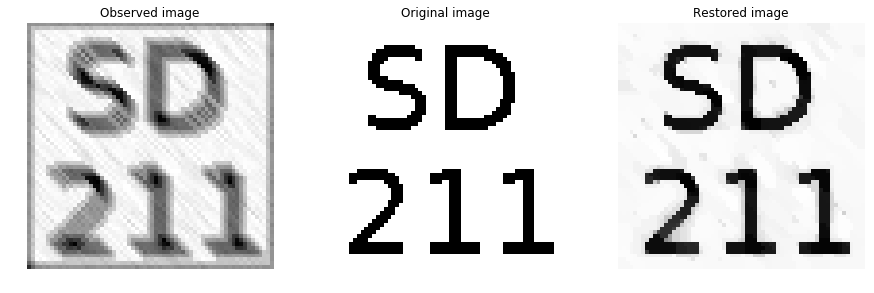

In [5]:
rho = 0.05
beta = 0.01
k_max = 100

t0 = time()
x_restored, k = ADMM(data['observations'], data['original'], data['H'], data['T'], beta, rho, k_max)
print "Done in %0.3fs." % (time()-t0)

plt.figure(2, figsize=(15,5))
plt.subplot(131)
plt.title("Observed image")
plt.imshow(data['observations'], cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.title("Original image")
plt.imshow(data['original'], cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.title("Restored image")
plt.imshow(x_restored, cmap='gray')
plt.axis('off')
plt.show()

$\textbf{Manipulation 3} \quad\text{Evaluer à chaque itération la valeur du Lagrangien augmenté et de l'EQM.}$

Done in 64.697s.


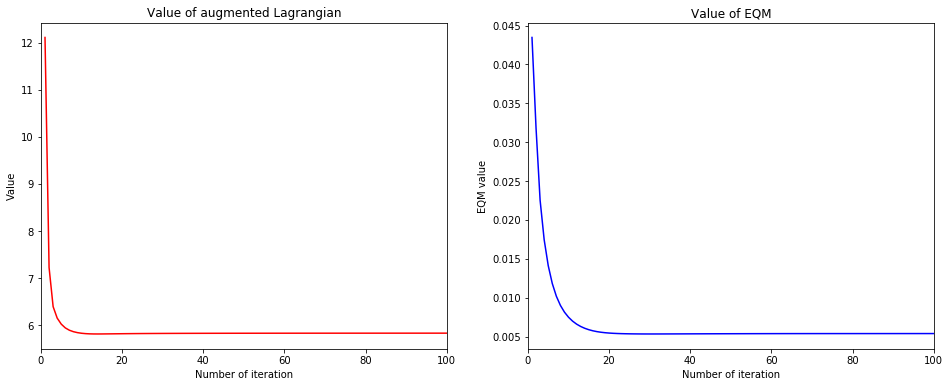

In [6]:
t0 = time()
x_restored, L, biais, EQM, k = ADMM(data['observations'], data['original'], data['H'], data['T'], beta, rho, k_max, return_iter_info=True)
print "Done in %0.3fs." % (time()-t0)

ite_range = range(1, k_max+1)

plt.figure(3, figsize=(16,6))
plt.subplot(121)
plt.title("Value of augmented Lagrangian")
plt.plot(ite_range, L, c='r')
plt.xlabel("Number of iteration")
plt.ylabel("Value")
plt.xlim(0, 100)
plt.subplot(122)
plt.title("Value of EQM")
plt.plot(ite_range, EQM, c='b')
plt.xlabel("Number of iteration")
plt.ylabel("EQM value")
plt.xlim(0, 100)
plt.show()

<div class="alert alert-success">
<p>
La courbe de la valeur du Lagrangien augmenté décroît très rapidement vers un certain valeur positive, après elle devient stable.
</p>

<p>
La courbe de l'EQM décroît un peu moins rapidement que l'autre, elle devient satble autour une petite valeur positive.
</p>
</div>

De plus, nous pouvons afficher le biais intuitivement.

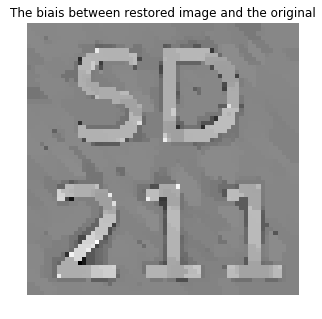

In [7]:
plt.figure(4, figsize=(5,5))
plt.title("The biais between restored image and the original")
plt.imshow(x_restored - data['original'], cmap='gray')
plt.axis('off')
plt.show()

$\textbf{Manipulation 4} \quad\text{Analyser l'influence de } \rho \text{ et de } \beta \text{ sur la solution et sur le problème d'optimisation.}$

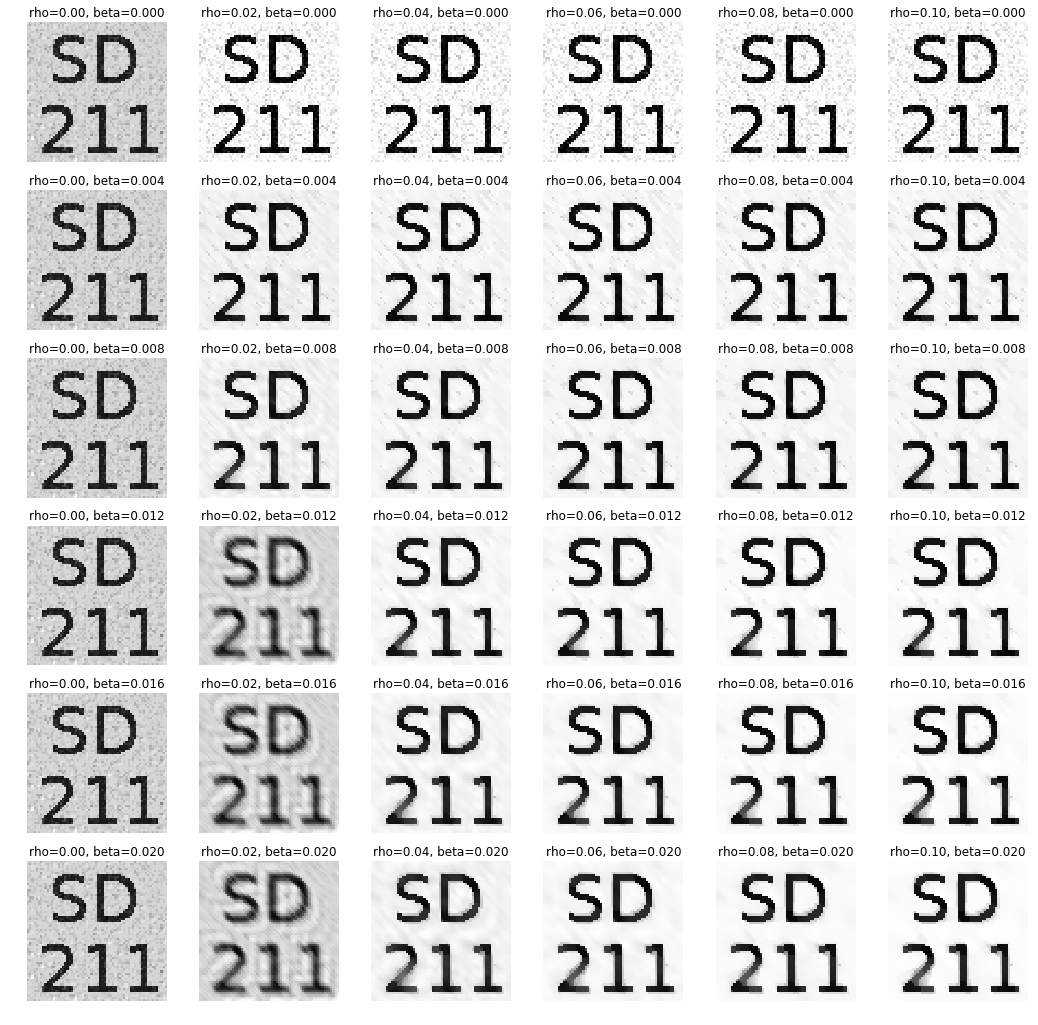

Done in 516.037s.


In [8]:
t0 = time()

arr_rho = np.append(np.finfo('float').eps, np.linspace(0.02, 0.1, 5))
arr_beta = np.linspace(0, 0.02, 6)
arr_rho, arr_beta = np.meshgrid(arr_rho, arr_beta)

arr_biais = np.empty_like(arr_rho, dtype=np.float32)
arr_EQM = np.empty_like(arr_rho, dtype=np.float32)
arr_L = np.empty_like(arr_rho, dtype=np.float32)
arr_k = np.empty_like(arr_rho, dtype=np.float32)

plt.close('all')
plt.figure(6, figsize=(18, 18))

for i in range(6):
    for j in range(6):
        rho = arr_rho[i][j]
        beta = arr_beta[i][j]
        x_restored, L, biais, EQM, k = ADMM(data['observations'], data['original'], data['H'], data['T'], beta, rho, k_max, early_stop=True, tol=1e-4, return_info=True)
        arr_biais[i][j] = biais
        arr_EQM[i][j] = EQM
        arr_L[i][j] = L
        arr_k[i][j] = k
        plt.subplot(6, 6, i*6+j+1)
        plt.title("rho=%0.2f, beta=%0.3f" % (rho, beta))
        plt.imshow(x_restored, cmap='gray')
        plt.axis('off')
plt.show()

print "Done in %0.3fs." % (time()-t0)

<div class="alert alert-success">
<p>
    Sur la qualité de la reconstruction, on peut conclure que quand la valeur de $\rho$ augmente, il y a moins de points de bruit.
</p>

<p>
    Quand la valeur de $\beta$ augmente les pixels adjacents deviennent de plus en plus continuels. D'abord, l'image est plus lisible, après, il devient flou encore une fois.
</p>
</div>

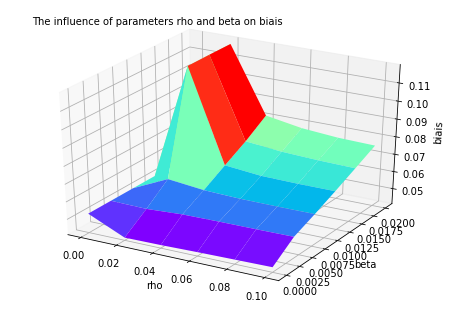

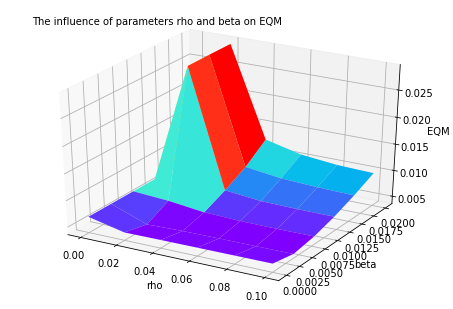

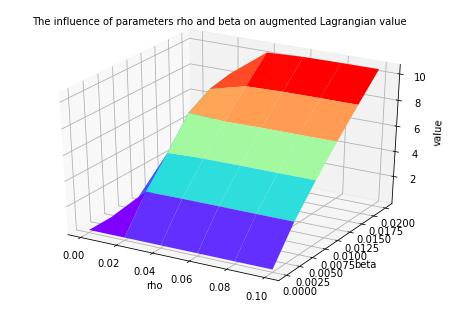

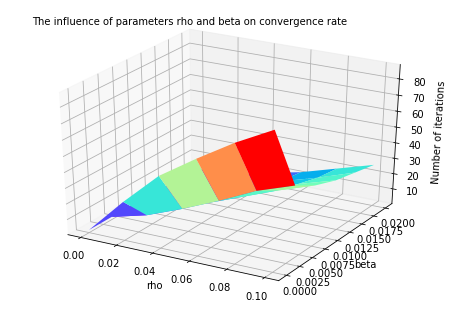

In [9]:
fig = plt.figure(6)
ax = Axes3D(fig)
ax.text2D(0.05, 0.95, "The influence of parameters rho and beta on biais", transform=ax.transAxes)
ax.plot_surface(arr_rho, arr_beta, arr_biais, cmap='rainbow')
ax.set_xlabel('rho')
ax.set_ylabel('beta')
ax.set_zlabel('biais')
plt.show()

fig = plt.figure(7)
ax = Axes3D(fig)
ax.text2D(0.05, 0.95, "The influence of parameters rho and beta on EQM", transform=ax.transAxes)
ax.plot_surface(arr_rho, arr_beta, arr_EQM, cmap='rainbow')
ax.set_xlabel('rho')
ax.set_ylabel('beta')
ax.set_zlabel('EQM')
plt.show()

fig = plt.figure(8)
ax = Axes3D(fig)
ax.text2D(0.05, 0.95, "The influence of parameters rho and beta on augmented Lagrangian value", transform=ax.transAxes)
ax.plot_surface(arr_rho, arr_beta, arr_L, cmap='rainbow')
ax.set_xlabel('rho')
ax.set_ylabel('beta')
ax.set_zlabel('value')
plt.show()

fig = plt.figure(9)
ax = Axes3D(fig)
ax.text2D(0.05, 0.95, "The influence of parameters rho and beta on convergence rate", transform=ax.transAxes)
ax.plot_surface(arr_rho, arr_beta, arr_k, cmap='rainbow')
ax.set_xlabel('rho')
ax.set_ylabel('beta')
ax.set_zlabel('Number of iterations')
plt.show()

<div class="alert alert-success">
<p>
Quand la valeur de $\rho$ augmente, le biais et l'EQM vont décroît, la valeur de Lagrangien augmenté va augmenter, le nombre nécessaire pour convergence va augmenter.
</p>

<p>
Quand la valeur de $\beta$ augmente, le biais, l'EQM et la valeur de Lagrangien augmenté vont augmenter, le nombre nécessaire pour convergence va décoire.
</p>
</div>

$\textbf{Facultatif}\quad\text{Ajouter un bruit additif gaussien de variance 0.1 à l'image et étudier son influence sur la reconstruction.}$

Done in 66.167s.


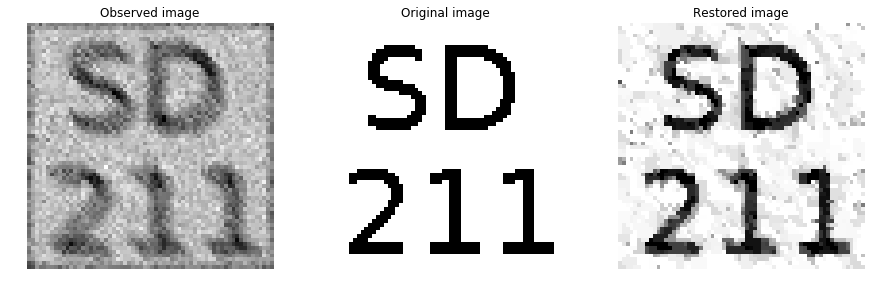

In [14]:
rho = 0.05
beta = 0.01
k_max = 100

y = data['observations'] + 0.1*np.random.randn(64,64)

t0 = time()
x_restored, k = ADMM(y, data['original'], data['H'], data['T'], beta, rho, k_max)
print "Done in %0.3fs." % (time()-t0)

plt.figure(10, figsize=(15,5))
plt.subplot(131)
plt.title("Observed image")
plt.imshow(y, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.title("Original image")
plt.imshow(data['original'], cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.title("Restored image")
plt.imshow(x_restored, cmap='gray')
plt.axis('off')
plt.show()

<div class="alert alert-success">
<p>
Le bruit additif va influencer la qualité de reconstruction.
</p>
</div>